# Domain adaptation

- Unsupervised Domain Adaptation by Backpropagation, Ganin & Lemptsky (2014)


![](da.png)

https://www.youtube.com/watch?v=uUUvieVxCMs&t=1210s

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Function
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
import mnistm
from PIL import Image

In [16]:
class GrayscaleToRgb:
    """Convert a grayscale image to rgb"""
    def __call__(self, image):
        image = np.array(image)
        image = np.dstack([image, image, image])
        return Image.fromarray(image)

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.MaxPool2d(2),
            nn.Dropout2d(),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        features = features.view(x.shape[0], -1)
        logits = self.classifier(features)
        return logits

In [8]:
# Taken from https://github.com/jvanvugt/pytorch-domain-adaptation/
class GradientReversalFunction(Function):
    """
    Gradient Reversal Layer from:
    Unsupervised Domain Adaptation by Backpropagation (Ganin & Lempitsky, 2015)
    Forward pass is the identity function. In the backward pass,
    the upstream gradients are multiplied by -lambda (i.e. gradient is reversed)
    """
    
    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.clone()

    @staticmethod
    def backward(ctx, grads):
        lambda_ = ctx.lambda_
        lambda_ = grads.new_tensor(lambda_)
        dx = -lambda_ * grads
        return dx, None

class GradientReversal(torch.nn.Module):
    def __init__(self, lambda_=1):
        super(GradientReversal, self).__init__()
        self.lambda_ = lambda_

    def forward(self, x):
        return GradientReversalFunction.apply(x, self.lambda_)

In [9]:
epochs=3
seed = 1101
batch_size = 64

use_cuda = torch.cuda.is_available()
torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [10]:
model = Net().to(device)

In [12]:
model.load_state_dict(torch.load('conv_for_domain_adaptation.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [13]:
feature_extractor = model.feature_extractor
clf = model.classifier

In [14]:
discriminator = nn.Sequential(
    GradientReversal(),
    nn.Linear(320, 50),
    nn.ReLU(),
    nn.Linear(50, 20),
    nn.ReLU(),
    nn.Linear(20, 1)
).to(device)

In [17]:
half_batch = batch_size // 2

source_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           GrayscaleToRgb(),
                           transforms.ToTensor(),                           
                       ])),
        batch_size=half_batch, shuffle=True, **kwargs)

In [19]:
target_loader = torch.utils.data.DataLoader( 
    mnistm.MNISTM('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),                           
                       ])), 
    batch_size=half_batch, shuffle=True, **kwargs)

In [20]:
imgs,labels = next(iter(target_loader))
print(imgs.shape)

torch.Size([32, 3, 28, 28])


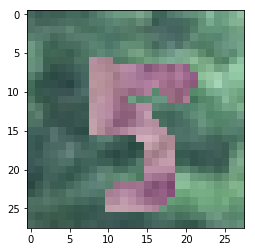

In [22]:
plt.imshow(np.transpose(imgs[10], (1,2,0)))
plt.show()

In [23]:
optim = torch.optim.Adam(list(discriminator.parameters()) + list(model.parameters()))

In [25]:
for epoch in range(1, epochs+1):
    batches = zip(source_loader, target_loader)
    n_batches = min(len(source_loader), len(target_loader))

    total_domain_loss = total_label_accuracy = 0
    for (source_x, source_labels), (target_x, _) in tqdm(batches, leave=False, total=n_batches):
            x = torch.cat([source_x, target_x])
            x = x.to(device)
            
            domain_y = torch.cat([torch.ones(source_x.shape[0]),
                                  torch.zeros(target_x.shape[0])])
            domain_y = domain_y.to(device)
            label_y = source_labels.to(device)

            features = feature_extractor(x).view(x.shape[0], -1)
            domain_preds = discriminator(features).squeeze()
            label_preds = clf(features[:source_x.shape[0]])

            domain_loss = F.binary_cross_entropy_with_logits(domain_preds, domain_y)
            label_loss = F.cross_entropy(label_preds, label_y)
            loss = domain_loss + label_loss

            optim.zero_grad()
            loss.backward()
            optim.step()

            total_domain_loss += domain_loss.item()
            total_label_accuracy += (label_preds.max(1)[1] == label_y).float().mean().item()

    mean_loss = total_domain_loss / n_batches
    mean_accuracy = total_label_accuracy / n_batches
    tqdm.write(f'EPOCH {epoch:03d}: domain_loss={mean_loss:.4f}, '
               f'source_accuracy={mean_accuracy:.4f}')

    torch.save(model.state_dict(), 'domain_adaptation/revgrad_' + str(epoch) + '.pt')




  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 3/1875 [00:00<01:04, 29.23it/s]

  0%|          | 7/1875 [00:00<01:01, 30.24it/s]

  1%|          | 11/1875 [00:00<00:57, 32.39it/s]

  1%|          | 15/1875 [00:00<00:54, 34.31it/s]

  1%|          | 19/1875 [00:00<00:52, 35.08it/s]

  1%|          | 23/1875 [00:00<00:51, 36.09it/s]

  1%|▏         | 28/1875 [00:00<00:49, 37.41it/s]

  2%|▏         | 32/1875 [00:00<00:49, 37.35it/s]

  2%|▏         | 36/1875 [00:00<00:49, 36.87it/s]

  2%|▏         | 40/1875 [00:01<00:49, 37.12it/s]

  2%|▏         | 44/1875 [00:01<00:50, 36.14it/s]

  3%|▎         | 48/1875 [00:01<00:51, 35.81it/s]

  3%|▎         | 53/1875 [00:01<00:47, 38.07it/s]

  3%|▎         | 58/1875 [00:01<00:45, 40.14it/s]

  3%|▎         | 63/1875 [00:01<00:45, 40.09it/s]

  4%|▎         | 68/1875 [00:01<00:45, 39.56it/s]

  4%|▍         | 72/1875 [00:01<00:47, 38.11it/s]

  4%|▍         | 76/1875 [00:02<00:48, 37.37it/s]

  4%|▍         | 80/1875 [00:02<00:51, 3

 37%|███▋      | 686/1875 [00:16<00:30, 38.47it/s]

 37%|███▋      | 690/1875 [00:16<00:30, 38.72it/s]

 37%|███▋      | 695/1875 [00:16<00:29, 39.82it/s]

 37%|███▋      | 700/1875 [00:16<00:27, 42.24it/s]

 38%|███▊      | 705/1875 [00:16<00:27, 42.14it/s]

 38%|███▊      | 710/1875 [00:16<00:28, 40.45it/s]

 38%|███▊      | 715/1875 [00:17<00:29, 39.60it/s]

 38%|███▊      | 719/1875 [00:17<00:29, 38.67it/s]

 39%|███▊      | 723/1875 [00:17<00:29, 38.47it/s]

 39%|███▉      | 727/1875 [00:17<00:29, 38.57it/s]

 39%|███▉      | 732/1875 [00:17<00:29, 39.12it/s]

 39%|███▉      | 736/1875 [00:17<00:29, 38.58it/s]

 39%|███▉      | 740/1875 [00:17<00:29, 38.24it/s]

 40%|███▉      | 745/1875 [00:17<00:27, 40.99it/s]

 40%|████      | 751/1875 [00:17<00:25, 44.28it/s]

 40%|████      | 757/1875 [00:18<00:23, 47.38it/s]

 41%|████      | 763/1875 [00:18<00:22, 49.69it/s]

 41%|████      | 769/1875 [00:18<00:21, 52.05it/s]

 41%|████▏     | 775/1875 [00:18<00:20, 53.38it/s]

 42%|████▏  

 80%|███████▉  | 1498/1875 [00:31<00:06, 54.63it/s]

 80%|████████  | 1504/1875 [00:31<00:07, 52.92it/s]

 81%|████████  | 1510/1875 [00:32<00:06, 53.81it/s]

 81%|████████  | 1516/1875 [00:32<00:06, 54.55it/s]

 81%|████████  | 1522/1875 [00:32<00:06, 53.30it/s]

 81%|████████▏ | 1528/1875 [00:32<00:06, 54.01it/s]

 82%|████████▏ | 1534/1875 [00:32<00:06, 54.54it/s]

 82%|████████▏ | 1540/1875 [00:32<00:06, 54.74it/s]

 82%|████████▏ | 1546/1875 [00:32<00:05, 55.13it/s]

 83%|████████▎ | 1552/1875 [00:32<00:06, 53.82it/s]

 83%|████████▎ | 1558/1875 [00:32<00:05, 53.25it/s]

 83%|████████▎ | 1564/1875 [00:33<00:05, 52.79it/s]

 84%|████████▎ | 1570/1875 [00:33<00:05, 52.66it/s]

 84%|████████▍ | 1576/1875 [00:33<00:05, 52.92it/s]

 84%|████████▍ | 1582/1875 [00:33<00:05, 53.89it/s]

 85%|████████▍ | 1588/1875 [00:33<00:05, 53.36it/s]

 85%|████████▌ | 1594/1875 [00:33<00:05, 53.22it/s]

 85%|████████▌ | 1600/1875 [00:33<00:05, 53.93it/s]

 86%|████████▌ | 1606/1875 [00:33<00:04, 54.30

EPOCH 001: domain_loss=0.4423, source_accuracy=0.9021




  0%|          | 9/1875 [00:00<00:45, 40.78it/s]

  1%|          | 14/1875 [00:00<00:43, 43.10it/s]

  1%|          | 20/1875 [00:00<00:40, 46.33it/s]

  1%|▏         | 26/1875 [00:00<00:37, 48.78it/s]

  2%|▏         | 32/1875 [00:00<00:36, 50.43it/s]

  2%|▏         | 38/1875 [00:00<00:35, 51.95it/s]

  2%|▏         | 44/1875 [00:00<00:34, 52.95it/s]

  3%|▎         | 50/1875 [00:00<00:34, 52.85it/s]

  3%|▎         | 56/1875 [00:01<00:33, 53.89it/s]

  3%|▎         | 62/1875 [00:01<00:33, 53.93it/s]

  4%|▎         | 68/1875 [00:01<00:33, 54.63it/s]

  4%|▍         | 74/1875 [00:01<00:33, 54.35it/s]

  4%|▍         | 80/1875 [00:01<00:32, 54.41it/s]

  5%|▍         | 86/1875 [00:01<00:32, 54.63it/s]

  5%|▍         | 92/1875 [00:01<00:32, 54.72it/s]

  5%|▌         | 98/1875 [00:01<00:32, 54.76it/s]

  6%|▌         | 104/1875 [00:01<00:32, 55.09it/s]

  6%|▌         | 110/1875 [00:02<00:31, 55.45it/s]

  6%|▌         | 116/1875 [00:02<00:31, 55.13it/s]

  7%|▋         | 122/1875 [

 45%|████▌     | 848/1875 [00:15<00:21, 48.23it/s]

 45%|████▌     | 853/1875 [00:15<00:20, 48.69it/s]

 46%|████▌     | 859/1875 [00:16<00:20, 50.11it/s]

 46%|████▌     | 865/1875 [00:16<00:19, 51.64it/s]

 46%|████▋     | 871/1875 [00:16<00:19, 52.26it/s]

 47%|████▋     | 877/1875 [00:16<00:18, 52.99it/s]

 47%|████▋     | 883/1875 [00:16<00:18, 53.99it/s]

 47%|████▋     | 889/1875 [00:16<00:18, 54.62it/s]

 48%|████▊     | 895/1875 [00:16<00:17, 54.72it/s]

 48%|████▊     | 901/1875 [00:16<00:19, 51.09it/s]

 48%|████▊     | 907/1875 [00:16<00:19, 48.76it/s]

 49%|████▊     | 912/1875 [00:17<00:20, 47.55it/s]

 49%|████▉     | 918/1875 [00:17<00:19, 49.41it/s]

 49%|████▉     | 923/1875 [00:17<00:20, 47.33it/s]

 49%|████▉     | 928/1875 [00:17<00:20, 47.17it/s]

 50%|████▉     | 933/1875 [00:17<00:20, 45.79it/s]

 50%|█████     | 939/1875 [00:17<00:19, 47.59it/s]

 50%|█████     | 945/1875 [00:17<00:18, 50.11it/s]

 51%|█████     | 951/1875 [00:17<00:18, 50.49it/s]

 51%|█████  

 84%|████████▎ | 1569/1875 [00:32<00:08, 37.44it/s]

 84%|████████▍ | 1573/1875 [00:32<00:08, 34.20it/s]

 84%|████████▍ | 1577/1875 [00:32<00:09, 31.94it/s]

 84%|████████▍ | 1581/1875 [00:32<00:09, 29.51it/s]

 85%|████████▍ | 1585/1875 [00:32<00:10, 26.87it/s]

 85%|████████▍ | 1588/1875 [00:32<00:12, 23.30it/s]

 85%|████████▍ | 1591/1875 [00:33<00:13, 20.95it/s]

 85%|████████▌ | 1594/1875 [00:33<00:13, 20.98it/s]

 85%|████████▌ | 1597/1875 [00:33<00:12, 23.03it/s]

 85%|████████▌ | 1601/1875 [00:33<00:10, 25.81it/s]

 86%|████████▌ | 1605/1875 [00:33<00:09, 28.56it/s]

 86%|████████▌ | 1609/1875 [00:33<00:08, 30.56it/s]

 86%|████████▌ | 1613/1875 [00:33<00:07, 32.78it/s]

 86%|████████▌ | 1617/1875 [00:33<00:07, 33.95it/s]

 87%|████████▋ | 1622/1875 [00:34<00:07, 35.70it/s]

 87%|████████▋ | 1626/1875 [00:34<00:06, 36.88it/s]

 87%|████████▋ | 1631/1875 [00:34<00:06, 38.05it/s]

 87%|████████▋ | 1635/1875 [00:34<00:06, 38.35it/s]

 87%|████████▋ | 1640/1875 [00:34<00:05, 39.79

EPOCH 002: domain_loss=0.5426, source_accuracy=0.9157




  0%|          | 7/1875 [00:00<01:01, 30.30it/s]

  1%|          | 12/1875 [00:00<00:54, 34.01it/s]

  1%|          | 18/1875 [00:00<00:48, 38.53it/s]

  1%|▏         | 24/1875 [00:00<00:43, 42.08it/s]

  2%|▏         | 30/1875 [00:00<00:40, 45.15it/s]

  2%|▏         | 35/1875 [00:00<00:39, 46.06it/s]

  2%|▏         | 41/1875 [00:00<00:37, 48.54it/s]

  3%|▎         | 47/1875 [00:00<00:36, 49.92it/s]

  3%|▎         | 53/1875 [00:01<00:35, 51.48it/s]

  3%|▎         | 59/1875 [00:01<00:35, 51.69it/s]

  3%|▎         | 65/1875 [00:01<00:34, 51.80it/s]

  4%|▍         | 71/1875 [00:01<00:34, 52.72it/s]

  4%|▍         | 77/1875 [00:01<00:33, 53.49it/s]

  4%|▍         | 83/1875 [00:01<00:33, 52.91it/s]

  5%|▍         | 89/1875 [00:01<00:35, 50.17it/s]

  5%|▌         | 95/1875 [00:01<00:37, 47.93it/s]

  5%|▌         | 101/1875 [00:02<00:35, 49.97it/s]

  6%|▌         | 107/1875 [00:02<00:34, 51.08it/s]

  6%|▌         | 113/1875 [00:02<00:33, 52.22it/s]

  6%|▋         | 119/1875 [

 41%|████      | 766/1875 [00:16<00:27, 40.25it/s]

 41%|████      | 771/1875 [00:16<00:27, 40.38it/s]

 41%|████▏     | 776/1875 [00:16<00:26, 40.92it/s]

 42%|████▏     | 782/1875 [00:17<00:24, 44.11it/s]

 42%|████▏     | 787/1875 [00:17<00:23, 45.72it/s]

 42%|████▏     | 792/1875 [00:17<00:24, 44.12it/s]

 43%|████▎     | 797/1875 [00:17<00:25, 42.74it/s]

 43%|████▎     | 802/1875 [00:17<00:25, 42.22it/s]

 43%|████▎     | 807/1875 [00:17<00:25, 41.65it/s]

 43%|████▎     | 812/1875 [00:17<00:25, 41.40it/s]

 44%|████▎     | 817/1875 [00:17<00:25, 41.19it/s]

 44%|████▍     | 822/1875 [00:18<00:25, 41.01it/s]

 44%|████▍     | 827/1875 [00:18<00:25, 40.86it/s]

 44%|████▍     | 832/1875 [00:18<00:26, 39.70it/s]

 45%|████▍     | 836/1875 [00:18<00:27, 38.38it/s]

 45%|████▍     | 840/1875 [00:18<00:27, 37.21it/s]

 45%|████▌     | 844/1875 [00:18<00:28, 36.41it/s]

 45%|████▌     | 848/1875 [00:18<00:28, 36.08it/s]

 45%|████▌     | 852/1875 [00:18<00:28, 35.67it/s]

 46%|████▌  

 72%|███████▏  | 1354/1875 [00:32<00:16, 31.85it/s]

 72%|███████▏  | 1358/1875 [00:33<00:16, 31.51it/s]

 73%|███████▎  | 1362/1875 [00:33<00:16, 31.67it/s]

 73%|███████▎  | 1366/1875 [00:33<00:16, 31.46it/s]

 73%|███████▎  | 1370/1875 [00:33<00:16, 31.26it/s]

 73%|███████▎  | 1374/1875 [00:33<00:16, 31.29it/s]

 73%|███████▎  | 1378/1875 [00:33<00:15, 31.53it/s]

 74%|███████▎  | 1382/1875 [00:33<00:15, 31.58it/s]

 74%|███████▍  | 1386/1875 [00:33<00:15, 31.47it/s]

 74%|███████▍  | 1390/1875 [00:34<00:15, 31.70it/s]

 74%|███████▍  | 1394/1875 [00:34<00:15, 31.56it/s]

 75%|███████▍  | 1398/1875 [00:34<00:14, 32.01it/s]

 75%|███████▍  | 1403/1875 [00:34<00:13, 34.57it/s]

 75%|███████▌  | 1408/1875 [00:34<00:13, 35.88it/s]

 75%|███████▌  | 1412/1875 [00:34<00:13, 34.74it/s]

 76%|███████▌  | 1416/1875 [00:34<00:13, 34.14it/s]

 76%|███████▌  | 1420/1875 [00:34<00:13, 33.30it/s]

 76%|███████▌  | 1424/1875 [00:35<00:13, 32.88it/s]

 76%|███████▌  | 1428/1875 [00:35<00:13, 32.27

EPOCH 003: domain_loss=0.5583, source_accuracy=0.9216


# Exercise

- Assess the performance of the model through all epochs on source and target dataset. You should define new loaders with a suitable batch size. Pay attention to the case of the source dataset. Plot the accuracy on source and target domains as a function of the epoch, including the 0 epoch, before domain adaptation.

- Visualize features before and after domain adaptation with T-SNE. Is it visible the feature adaptation?

- Compute the ID of source and target features beore and  during the domain adaptation. What do you expect to see?